# Import and Catalogues

In [106]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment
import all_fctns
import matplotlib.colors as mcolors
from itertools import combinations
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp

SAMI_Target_catalogues = ("InputCatGAMADR3.fits", "InputCatClustersDR3.fits", "InputCatFiller.fits")
SAMI_regions = {0: "GAMA", 1: "Clusters", 2: "Filler"}

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir + "Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
SAMI_AGN_summary_catalogue = "Crossmatched\\SAMI_AGN_matches.fits"
SAMI_cubeobs_catalogue = "CubeObs.fits"

shared_catalogue_filepath = Source_dir +  "SAMI_TOOLS_SMC_MSPA4681\\shared_catalogues\\"
gassig_statistics_catalogue = "gassig_statistics.fits"

def refresh_module():
    import importlib
    import all_fctns
    importlib.reload(all_fctns)


with fits.open(catalogue_filepath + "\\Crossmatched\\SAMI_AGN_matches.fits") as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_SFR_catalogue) as SAMI_SFR_hdul:
    SAMI_SFR_table_hdu = Table(SAMI_SFR_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_cubeobs_catalogue) as SAMI_CubeObs_hdul:
    SAMI_CubeObs_table_hdu =  Table(SAMI_CubeObs_hdul[1].data)

with fits.open(shared_catalogue_filepath + gassig_statistics_catalogue) as gassig_statistics_hdul:
    gassig_statistics_table = Table(gassig_statistics_hdul[1].data)

AGN_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10])
HII_Composite_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [0, 1, 2])
possible_AGN_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [3, 4, 5])
inconclusive_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [-1, 999999])
na_mask = Summary_table_hdu['CATEGORY_BPT_AGN'] == 999999


AGN_CATIDs = Summary_table_hdu['CATID'][AGN_mask]
HII_Composite_CATIDs = Summary_table_hdu['CATID'][HII_Composite_mask]

AGN_colour = 'red'
HII_Composite_colour = 'blue'
possible_AGN_colour = 'orange'
inconclusive_colour = 'grey'


BPT_classification_dict = {'AGN BPT': (AGN_mask, AGN_colour),
                            'Possible AGN BPT': (possible_AGN_mask, possible_AGN_colour),
                           'HII/Composite': (HII_Composite_mask, HII_Composite_colour),
                           'Inconclusive': (inconclusive_mask, inconclusive_colour)}

BPT_classification_dict_handles = {key: plt.Line2D([0], [0], marker='o', color='w', label=key, linestyle='None', markersize=10, markerfacecolor=value[1]) for key, value in BPT_classification_dict.items()} # for the legends


radiosource_mask = Summary_table_hdu['IS_RADIOSOURCE'] ==1
xraysource_mask = Summary_table_hdu['IS_XRAYSOURCE'] == 1
HERG_mask = Summary_table_hdu['IS_HERG'] == 1
LERG_mask = Summary_table_hdu['IS_HERG'] == 0

radiosource_only_mask = radiosource_mask & ~xraysource_mask
xraysource_only_mask = xraysource_mask & ~radiosource_mask
xray_and_radiosource_mask = radiosource_mask & xraysource_mask
nosource_mask = ~radiosource_mask & ~xraysource_mask


nosource_marker  = 'o'
radiosource_marker = '|'
xraysource_marker = '_'
xray_and_radiosource_marker = '+'

radiosource_linestyle = '--'
xraysource_linestyle = '-.'
xray_and_radiosource_linestyle = ':'

nosource_colour = 'grey'
radiosource_colour = 'lime'
xraysource_colour = 'dodgerblue'
xray_and_radiosource_colour = 'turquoise'


# Define a dictionary to hold the source type information. Format is: source_type_dict = {'Source Type': (mask, marker, linestyle, point_size, colour)}
source_type_dict = {'Radio and X-ray Source': (xray_and_radiosource_mask, xray_and_radiosource_marker, xray_and_radiosource_linestyle, 20, xray_and_radiosource_colour),
                    'Only Radio Source': (radiosource_only_mask, radiosource_marker, radiosource_linestyle, 20, radiosource_colour),
                    'Only X-ray Source': (xraysource_only_mask, xraysource_marker, xraysource_linestyle, 20, xraysource_colour),
                    'No Match': ( nosource_mask, nosource_marker, '-' , 2, nosource_colour),}

source_type_dict_handles = {key: plt.Line2D([0], [0], marker=value[1], color='k', label=key, markersize=10, linestyle='None') for key, value in source_type_dict.items()} # for the legends



# radio/AGN dictionary
AGN_and_radiosource_mask = radiosource_mask & (AGN_mask | possible_AGN_mask) #HERG
AGN_and_not_radiosource_mask = (AGN_mask | possible_AGN_mask) & ~radiosource_mask
not_AGN_and_radiosource_mask = radiosource_mask & ~(AGN_mask | possible_AGN_mask)
not_AGN_and_not_radiosource_mask = ~radiosource_mask & ~(AGN_mask | possible_AGN_mask)

HERG_colour = AGN_colour
LERG_colour = inconclusive_colour

radiosource_AGN_dict = {'HERG': (HERG_mask, AGN_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Radio-quiet AGN': (AGN_and_not_radiosource_mask, AGN_colour, nosource_marker, '-', 2),
                        'LERG': (LERG_mask, inconclusive_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Not AGN BPT & Radio-quiet': (not_AGN_and_not_radiosource_mask, inconclusive_colour, nosource_marker, '-', 2)}


LINER_colour = 'green'
radiosource_LINER_dict = {'Radio-loud LINER': (AGN_and_radiosource_mask, LINER_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Radio-quiet LINER': (AGN_and_not_radiosource_mask, LINER_colour, nosource_marker, '-', 2),
                     #   'LERG': (not_AGN_and_radiosource_mask, inconclusive_colour, radiosource_marker, radiosource_linestyle, 20),
                        'Not AGN BPT & Radio-quiet': (not_AGN_and_not_radiosource_mask, inconclusive_colour, nosource_marker, '-', 2)}


AGN_colour = 'blue'
nonAGN_colour = 'red'
radioAGN_colour = 'blue'
nonradioAGN_colour = 'lightblue'
nonradioNonAGN_colour = 'red'
radioLINER_colour = 'green'
nonradioLINER_colour = 'limegreen'
nonAGN_colour = 'red'

HERG_colour = 'purple'
LERG_colour = 'magenta'

# getting valid table

In [2]:
joined_gassig_summary_table = join(Summary_table_hdu, gassig_statistics_table, keys='CATID', join_type='left')
na_mask = np.isnan(Summary_table_hdu['M_STAR']) | np.isnan(Summary_table_hdu['SFR_SAMI'])
gassig_statistic_nan_CATIDs = gassig_statistics_table['CATID'][np.isnan(gassig_statistics_table['5SPAXEL_MEDIAN_VEL_DISP']) | np.isnan(gassig_statistics_table['OUTSIDE_5SPAXEL_VEL_DISP'])]
valid_Summary_table_hdu = Summary_table_hdu[~na_mask & ~np.isin(Summary_table_hdu['CATID'], gassig_statistic_nan_CATIDs)]


# AGN and non-AGN

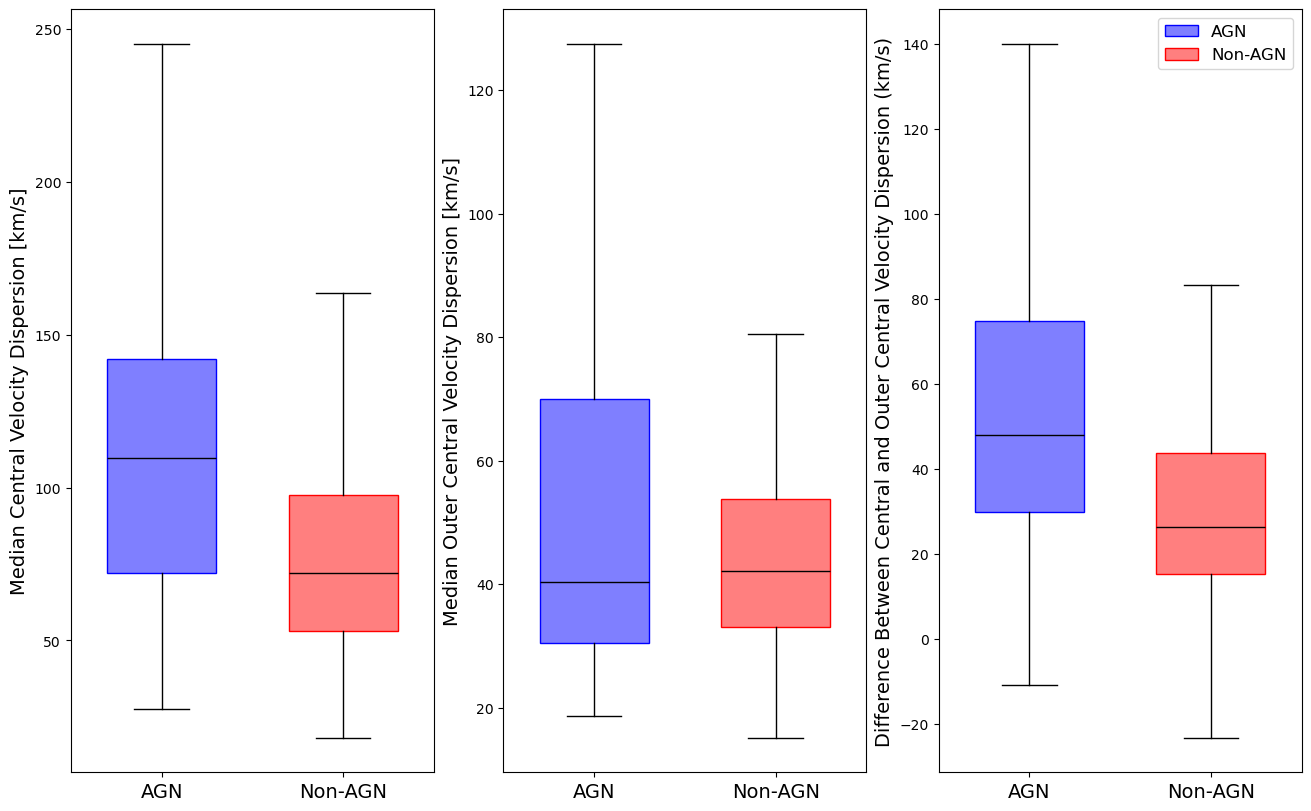

In [3]:
valid_AGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10])
valid_nonAGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [ -1, 0, 1, 2])

valid_AGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_AGN_mask]
valid_nonAGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_nonAGN_mask]

matched_AGN_nonAGN_table = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_AGN_CATIDs, valid_nonAGN_CATIDs,  distribution_plots=False, scatter_plot=False)
matched_AGN_nonAGN_table.rename_column('Input_CATID', 'AGN_CATID')
matched_AGN_nonAGN_table.rename_column('Matched_CATID', 'nonAGN_CATID')

matched_AGN_CATIDs = matched_AGN_nonAGN_table['AGN_CATID']
matched_nonAGN_CATIDs = matched_AGN_nonAGN_table['nonAGN_CATID']

matched_AGN_nonAGN_table = join(matched_AGN_nonAGN_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='AGN_CATID', keys_right='CATID', join_type='left')
matched_AGN_nonAGN_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['AGN_5SPAXEL_MEDIAN_VEL_DISP', 'AGN_OUTSIDE_5SPAXEL_VEL_DISP'])
matched_AGN_nonAGN_table = join(matched_AGN_nonAGN_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='nonAGN_CATID', keys_right='CATID', join_type='left')
matched_AGN_nonAGN_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['nonAGN_5SPAXEL_MEDIAN_VEL_DISP', 'nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'])

# remove any rows with NaN values in either of the 5SPAXEL_MEDIAN_VEL_DISP columns
central_disp_nan_mask = np.isnan(matched_AGN_nonAGN_table['AGN_5SPAXEL_MEDIAN_VEL_DISP']) | np.isnan(matched_AGN_nonAGN_table['nonAGN_5SPAXEL_MEDIAN_VEL_DISP'])
outside_central_disp_nan_mask = np.isnan(matched_AGN_nonAGN_table['AGN_OUTSIDE_5SPAXEL_VEL_DISP']) | np.isnan(matched_AGN_nonAGN_table['nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'])


gassig_statistics = ('5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP')
ylabels = ('Median Central Velocity Dispersion [km/s]', 'Median Outer Central Velocity Dispersion [km/s]')
AGN_colour = 'blue'
nonAGN_colour = 'red'
showfliers = False
fig, axs = plt.subplots(1,3, figsize=(13, 8), constrained_layout=True)
axs = axs.flatten()

for i, gassig_statistic in enumerate(gassig_statistics):
    gassig_statistic_mask =  np.isnan(matched_AGN_nonAGN_table[f'AGN_{gassig_statistic}']) | np.isnan(matched_AGN_nonAGN_table[f'nonAGN_{gassig_statistic}'])
    temporary_matched_table = matched_AGN_nonAGN_table[~gassig_statistic_mask]
    ax = axs[i]
    ax.boxplot(temporary_matched_table[f'AGN_{gassig_statistic}'], positions=[1], widths=0.6, patch_artist=True, boxprops
				=dict(facecolor=mcolors.to_rgba(AGN_colour, 0.5), color=AGN_colour), medianprops=dict(color='black'), showfliers=showfliers)
    ax.boxplot(temporary_matched_table[f'nonAGN_{gassig_statistic}'], positions=[2], widths=0.6, patch_artist=True, boxprops
				=dict(facecolor=mcolors.to_rgba(nonAGN_colour, 0.5), color=nonAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['AGN', 'Non-AGN'], fontsize=14)
    ax.set_ylabel(ylabels[i], fontsize=14)
# matched_AGN_nonAGN_table

# plot difference between central and Outer central dispersion boxplot
temporary_matched_table = matched_AGN_nonAGN_table[~central_disp_nan_mask & ~outside_central_disp_nan_mask]
ax=axs[2]
ax.boxplot(temporary_matched_table['AGN_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['AGN_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[1], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(AGN_colour, 0.5), color=AGN_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.boxplot(temporary_matched_table['nonAGN_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[2], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonAGN_colour, 0.5), color=nonAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)


ax.set_xticks([1, 2])
ax.set_xticklabels(['AGN', 'Non-AGN'], fontsize=14)
ax.set_ylabel('Difference Between Central and Outer Central Velocity Dispersion (km/s)', fontsize=14)
ax.legend(['AGN', 'Non-AGN'], fontsize=12)
plt.show()


# Radio loud AGN v Radio Quiet AGN v non-AGN

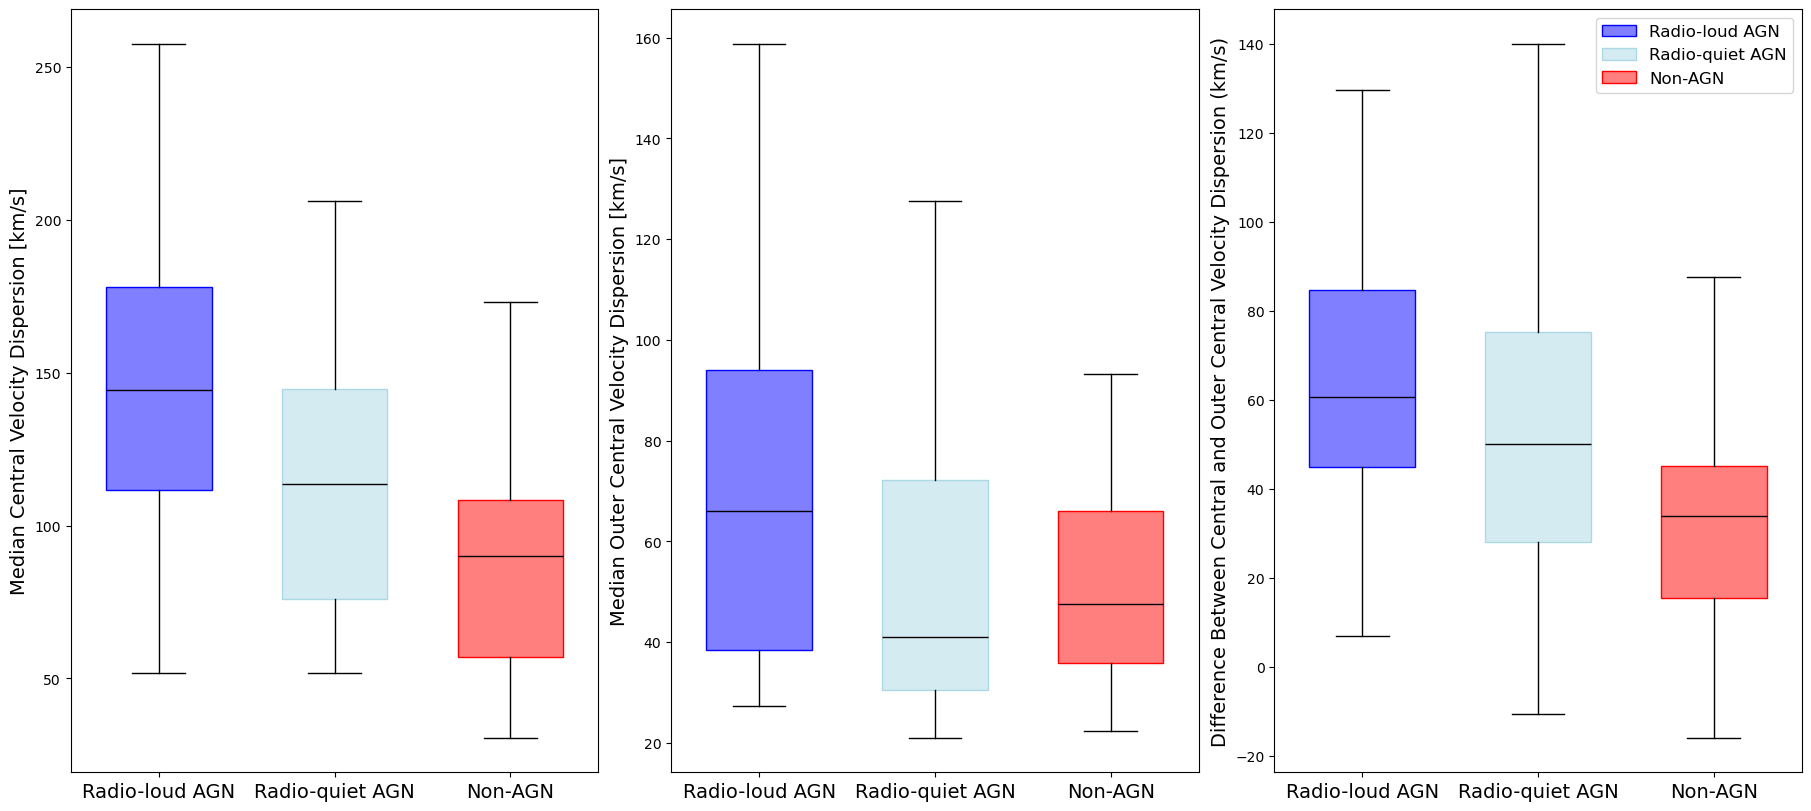

In [9]:
valid_radio_loud_AGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 1)
valid_radio_quiet_AGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 0)
valid_nonAGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [ -1, 0, 1, 2])

valid_radio_loud_AGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_radio_loud_AGN_mask]
valid_radio_quiet_AGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_radio_quiet_AGN_mask]
valid_nonAGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_nonAGN_mask]

matched_radio_loud_AGN_radio_quiet_AGN_table = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radio_loud_AGN_CATIDs, valid_radio_quiet_AGN_CATIDs,  distribution_plots=False, scatter_plot=False)
matched_radio_loud_AGN_radio_quiet_AGN_table.rename_column('Input_CATID', 'radio_loud_AGN_CATID')
matched_radio_loud_AGN_radio_quiet_AGN_table.rename_column('Matched_CATID', 'radio_quiet_AGN_CATID')

matched_radio_loud_AGN_nonAGN_table = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radio_loud_AGN_CATIDs, valid_nonAGN_CATIDs,  distribution_plots=False, scatter_plot=False)
matched_radio_loud_AGN_nonAGN_table.rename_column('Input_CATID', 'radio_loud_AGN_CATID')
matched_radio_loud_AGN_nonAGN_table.rename_column('Matched_CATID', 'nonAGN_CATID')

full_matched_table = join(matched_radio_loud_AGN_radio_quiet_AGN_table, matched_radio_loud_AGN_nonAGN_table, keys='radio_loud_AGN_CATID', join_type='outer')
full_matched_table = join(full_matched_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='radio_loud_AGN_CATID', keys_right='CATID', join_type='left')
full_matched_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['radio_loud_AGN_5SPAXEL_MEDIAN_VEL_DISP', 'radio_loud_AGN_OUTSIDE_5SPAXEL_VEL_DISP'])
full_matched_table = join(full_matched_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='radio_quiet_AGN_CATID', keys_right='CATID', join_type='left')
full_matched_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['radio_quiet_AGN_5SPAXEL_MEDIAN_VEL_DISP', 'radio_quiet_AGN_OUTSIDE_5SPAXEL_VEL_DISP'])
full_matched_table = join(full_matched_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='nonAGN_CATID', keys_right='CATID', join_type='left')
full_matched_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['nonAGN_5SPAXEL_MEDIAN_VEL_DISP', 'nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'])

full_matched_table

gassig_statistics = ('5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP')
ylabels = ('Median Central Velocity Dispersion [km/s]', 'Median Outer Central Velocity Dispersion [km/s]')

radioAGN_colour = 'blue'
nonradioAGN_colour = 'lightblue'
nonradioNonAGN_colour = 'red'
showfliers = False

fig, axs = plt.subplots(1,3, figsize=(18, 8), constrained_layout=True)
axs = axs.flatten()

samples_dict = {'Radio-loud AGN': ('radio_loud_AGN', radioAGN_colour,  0),
                'Radio-quiet AGN': ('radio_quiet_AGN', nonradioAGN_colour, 1),
                'Non-AGN': ('nonAGN', nonradioNonAGN_colour, 2)}


for i, gassig_statistic in enumerate(gassig_statistics):
    # get the mask of all valid gassig_statistic values
    gassig_statistic_mask = np.zeros_like(full_matched_table['radio_loud_AGN_CATID'], dtype=bool)
    for sample_name, (sample_prefix, _, _) in samples_dict.items():
        gassig_statistic_mask = gassig_statistic_mask | np.isnan(full_matched_table[f'{sample_prefix}_{gassig_statistic}'])
        pass

    temporary_matched_table = full_matched_table[~gassig_statistic_mask]
    ax = axs[i]

    for sample_name, (sample_prefix, sample_colour, j) in samples_dict.items():
        ax.boxplot(temporary_matched_table[f'{sample_prefix}_{gassig_statistic}'], positions=[j+1], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(sample_colour, 0.5), color=sample_colour), medianprops=dict(color='black'), showfliers=showfliers)

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels([keys for keys in samples_dict.keys()], fontsize=14)
    # ax.set_xticklabels(['Radio-loud AGN', 'Radio-quiet AGN', 'Non-AGN'], fontsize=14)
    ax.set_ylabel(ylabels[i], fontsize=14)


central_disp_nan_mask = np.isnan(full_matched_table['radio_loud_AGN_5SPAXEL_MEDIAN_VEL_DISP']) | np.isnan(full_matched_table['radio_quiet_AGN_5SPAXEL_MEDIAN_VEL_DISP']) | np.isnan(full_matched_table['nonAGN_5SPAXEL_MEDIAN_VEL_DISP'])
outside_central_disp_nan_mask = np.isnan(full_matched_table['radio_loud_AGN_OUTSIDE_5SPAXEL_VEL_DISP']) | np.isnan(full_matched_table['radio_quiet_AGN_OUTSIDE_5SPAXEL_VEL_DISP']) | np.isnan(full_matched_table['nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'])

# plot difference between central and Outer central dispersion boxplot
temporary_matched_table = full_matched_table[~central_disp_nan_mask & ~outside_central_disp_nan_mask]
ax =axs[2]
ax.boxplot(temporary_matched_table['radio_loud_AGN_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['radio_loud_AGN_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[1], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(radioAGN_colour, 0.5), color=radioAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.boxplot(temporary_matched_table['radio_quiet_AGN_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['radio_quiet_AGN_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[2], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonradioAGN_colour, 0.5), color=nonradioAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.boxplot(temporary_matched_table['nonAGN_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[3], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonradioNonAGN_colour, 0.5), color=nonradioNonAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Radio-loud AGN', 'Radio-quiet AGN', 'Non-AGN'], fontsize=14)
ax.set_ylabel('Difference Between Central and Outer Central Velocity Dispersion (km/s)', fontsize=14)
ax.legend(['Radio-loud AGN', 'Radio-quiet AGN', 'Non-AGN'], fontsize=12)
plt.show()


## get a violin plot of these above (only central and outer ones)

Radio-loud AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 144.5523910522461, -15.082870483398438, +10.413566589355469
Radio-quiet AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 113.68123245239258, -4.644111633300781, +3.090839385986328
Non-AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 89.93312072753906, -12.271514892578125, +5.366386413574219
Radio-loud AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 66.07212829589844, -7.014373779296875, +6.941978454589844
Radio-quiet AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 40.99929618835449, -5.787290573120117, +12.300745010375977
Non-AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 47.470964431762695, -1.4054698944091797, +5.715879440307617


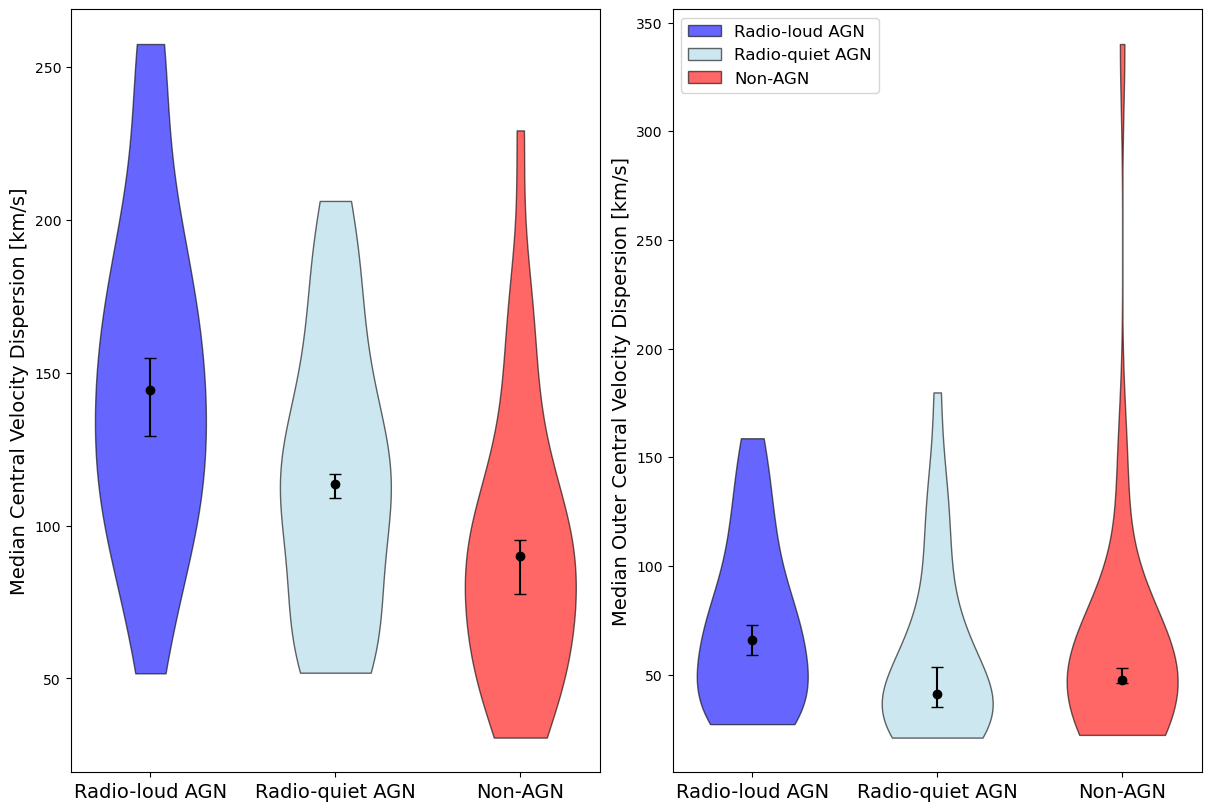

In [49]:
def bootstrap_median_ci(x, n_boot=1000, ci=68):
    boots = np.median(np.random.choice(x, (n_boot, len(x))), axis=1)
    med = np.median(x)
    err = np.percentile(boots, [50 - ci/2, 50 + ci/2])
    return med, med - err[0], err[1] - med   # median, lower_err, upper_err



fig, axs = plt.subplots(1,2, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()

for i, gassig_statistic in enumerate(gassig_statistics):
    # get the mask of all valid gassig_statistic values
    gassig_statistic_mask = np.zeros_like(full_matched_table['radio_loud_AGN_CATID'], dtype=bool)
    for sample_name, (sample_prefix, _, _) in samples_dict.items():
        gassig_statistic_mask = gassig_statistic_mask | np.isnan(full_matched_table[f'{sample_prefix}_{gassig_statistic}'])
        pass

    temporary_matched_table = full_matched_table[~gassig_statistic_mask]
    ax = axs[i]


    # plot the means and confidence intervals using bootstrapping
    for sample_name, (sample_prefix, sample_colour, j) in samples_dict.items():
        data = temporary_matched_table[f'{sample_prefix}_{gassig_statistic}']
        med, lower_err, upper_err = bootstrap_median_ci(data)
        print(f"{sample_name} - {gassig_statistic}: Median = {med}, -{lower_err}, +{upper_err}")


        # big-endian data need to convert to little-endian
        data = data.astype(data.dtype.newbyteorder('='))

        # violin plot
        parts = ax.violinplot(data, positions=[j+1], widths=0.6, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(mcolors.to_rgba(sample_colour, 0.5))
            pc.set_edgecolor('black')
            pc.set_alpha(0.6)

        # plot median and error bars
        ax.errorbar(j+1, med, yerr=[[lower_err], [upper_err]], fmt='o', color='black', capsize=4, lw=1.5, label='Median with 68% CI' if j==0 else "")

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels([keys for keys in samples_dict.keys()], fontsize=14)
    # ax.set_xticklabels(['Radio-loud AGN', 'Radio-quiet AGN', 'Non-AGN'], fontsize=14)
    ax.set_ylabel(ylabels[i], fontsize=14)

    if i==1:
        ax.legend([keys for keys in samples_dict.keys()], fontsize=12)

for ax in axs:
    ax.yaxis.set_tick_params(labelleft=True)
    ax.yaxis.offsetText.set_visible(True)  # show scientific notation if used


plt.show()


# Radio loud LINER v Radio Quiet LINER v Non-AGN

only 5 in the matched version so pretty useless

17


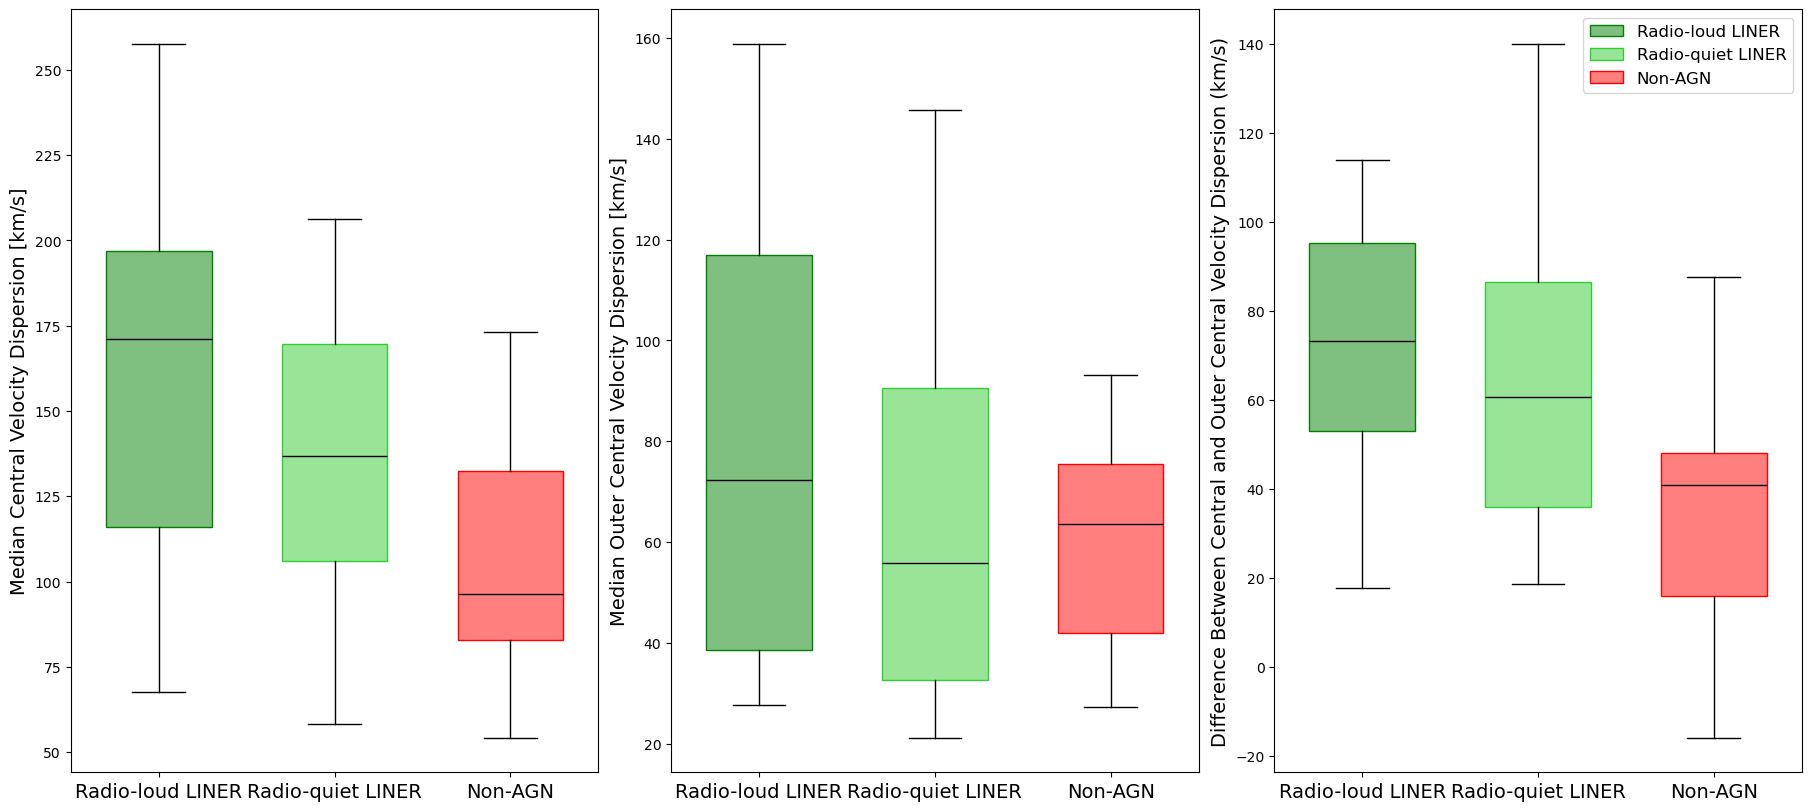

In [5]:
valid_radio_loud_LINER_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 1)
valid_radio_quiet_LINER_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 0)
valid_nonAGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [ -1, 0, 1, 2])

valid_radio_loud_LINER_CATIDs = valid_Summary_table_hdu['CATID'][valid_radio_loud_LINER_mask]
valid_radio_quiet_LINER_CATIDs = valid_Summary_table_hdu['CATID'][valid_radio_quiet_LINER_mask]
valid_nonAGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_nonAGN_mask]

matched_radio_loud_LINER_radio_quiet_LINER_table = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radio_loud_LINER_CATIDs, valid_radio_quiet_LINER_CATIDs,  distribution_plots=False, scatter_plot=False)
matched_radio_loud_LINER_radio_quiet_LINER_table.rename_column('Input_CATID', 'radio_loud_LINER_CATID')
matched_radio_loud_LINER_radio_quiet_LINER_table.rename_column('Matched_CATID', 'radio_quiet_LINER_CATID')
matched_radio_loud_LINER_nonAGN_table = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_radio_loud_LINER_CATIDs, valid_nonAGN_CATIDs,  distribution_plots=False, scatter_plot=False)
matched_radio_loud_LINER_nonAGN_table.rename_column('Input_CATID', 'radio_loud_LINER_CATID')
matched_radio_loud_LINER_nonAGN_table.rename_column('Matched_CATID', 'nonAGN_CATID')

full_matched_LINER_table = join(matched_radio_loud_LINER_radio_quiet_LINER_table, matched_radio_loud_LINER_nonAGN_table, keys='radio_loud_LINER_CATID', join_type='outer')
full_matched_LINER_table = join(full_matched_LINER_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='radio_loud_LINER_CATID', keys_right='CATID', join_type='left')
full_matched_LINER_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['radio_loud_LINER_5SPAXEL_MEDIAN_VEL_DISP', 'radio_loud_LINER_OUTSIDE_5SPAXEL_VEL_DISP'])
full_matched_LINER_table = join(full_matched_LINER_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='radio_quiet_LINER_CATID', keys_right='CATID', join_type='left')
full_matched_LINER_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['radio_quiet_LINER_5SPAXEL_MEDIAN_VEL_DISP', 'radio_quiet_LINER_OUTSIDE_5SPAXEL_VEL_DISP'])
full_matched_LINER_table = join(full_matched_LINER_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left='nonAGN_CATID', keys_right='CATID', join_type='left')
full_matched_LINER_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['nonAGN_5SPAXEL_MEDIAN_VEL_DISP', 'nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'])

gassig_statistics = ('5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP')
ylabels = ('Median Central Velocity Dispersion [km/s]', 'Median Outer Central Velocity Dispersion [km/s]')
LINER_colour = 'green'
nonLINER_colour = 'limegreen'
nonAGN_colour = 'red'
showfliers = False
fig, axs = plt.subplots(1,3, figsize=(18, 8), constrained_layout=True)

for i, gassig_statistic in enumerate(gassig_statistics):
    gassig_statistic_mask =  np.isnan(full_matched_LINER_table[f'radio_loud_LINER_{gassig_statistic}']) | np.isnan(full_matched_LINER_table[f'radio_quiet_LINER_{gassig_statistic}']) | np.isnan(full_matched_LINER_table[f'nonAGN_{gassig_statistic}'])
    temporary_matched_table = full_matched_LINER_table[~gassig_statistic_mask]
    ax = axs[i]
    ax.boxplot(temporary_matched_table[f'radio_loud_LINER_{gassig_statistic}'], positions=[1], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(LINER_colour, 0.5), color=LINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
    ax.boxplot(temporary_matched_table[f'radio_quiet_LINER_{gassig_statistic}'], positions=[2], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonLINER_colour, 0.5), color=nonLINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
    ax.boxplot(temporary_matched_table[f'nonAGN_{gassig_statistic}'], positions=[3], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonAGN_colour, 0.5), color=nonAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Radio-loud LINER', 'Radio-quiet LINER', 'Non-AGN'], fontsize=14)
    ax.set_ylabel(ylabels[i], fontsize=14)

# plot difference between central and Outer central dispersion boxplot
central_disp_nan_mask = np.isnan(full_matched_LINER_table['radio_loud_LINER_5SPAXEL_MEDIAN_VEL_DISP']) | np.isnan(full_matched_LINER_table['radio_quiet_LINER_5SPAXEL_MEDIAN_VEL_DISP']) | np.isnan(full_matched_LINER_table['nonAGN_5SPAXEL_MEDIAN_VEL_DISP'])
outside_central_disp_nan_mask = np.isnan(full_matched_LINER_table['radio_loud_LINER_OUTSIDE_5SPAXEL_VEL_DISP']) | np.isnan(full_matched_LINER_table['radio_quiet_LINER_OUTSIDE_5SPAXEL_VEL_DISP']) | np.isnan(full_matched_LINER_table['nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'])
temporary_matched_table = full_matched_LINER_table[~central_disp_nan_mask & ~outside_central_disp_nan_mask]
print(len(temporary_matched_table))
ax =axs[2]
ax.boxplot(temporary_matched_table['radio_loud_LINER_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['radio_loud_LINER_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[1], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(LINER_colour, 0.5), color=LINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.boxplot(temporary_matched_table['radio_quiet_LINER_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['radio_quiet_LINER_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[2], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonLINER_colour, 0.5), color=nonLINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.boxplot(temporary_matched_table['nonAGN_5SPAXEL_MEDIAN_VEL_DISP'] - temporary_matched_table['nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'], positions=[3], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonAGN_colour, 0.5), color=nonAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Radio-loud LINER', 'Radio-quiet LINER', 'Non-AGN'], fontsize=14)
ax.set_ylabel('Difference Between Central and Outer Central Velocity Dispersion (km/s)', fontsize=14)
ax.legend(['Radio-loud LINER', 'Radio-quiet LINER', 'Non-AGN'], fontsize=12)
plt.show()


## not matched

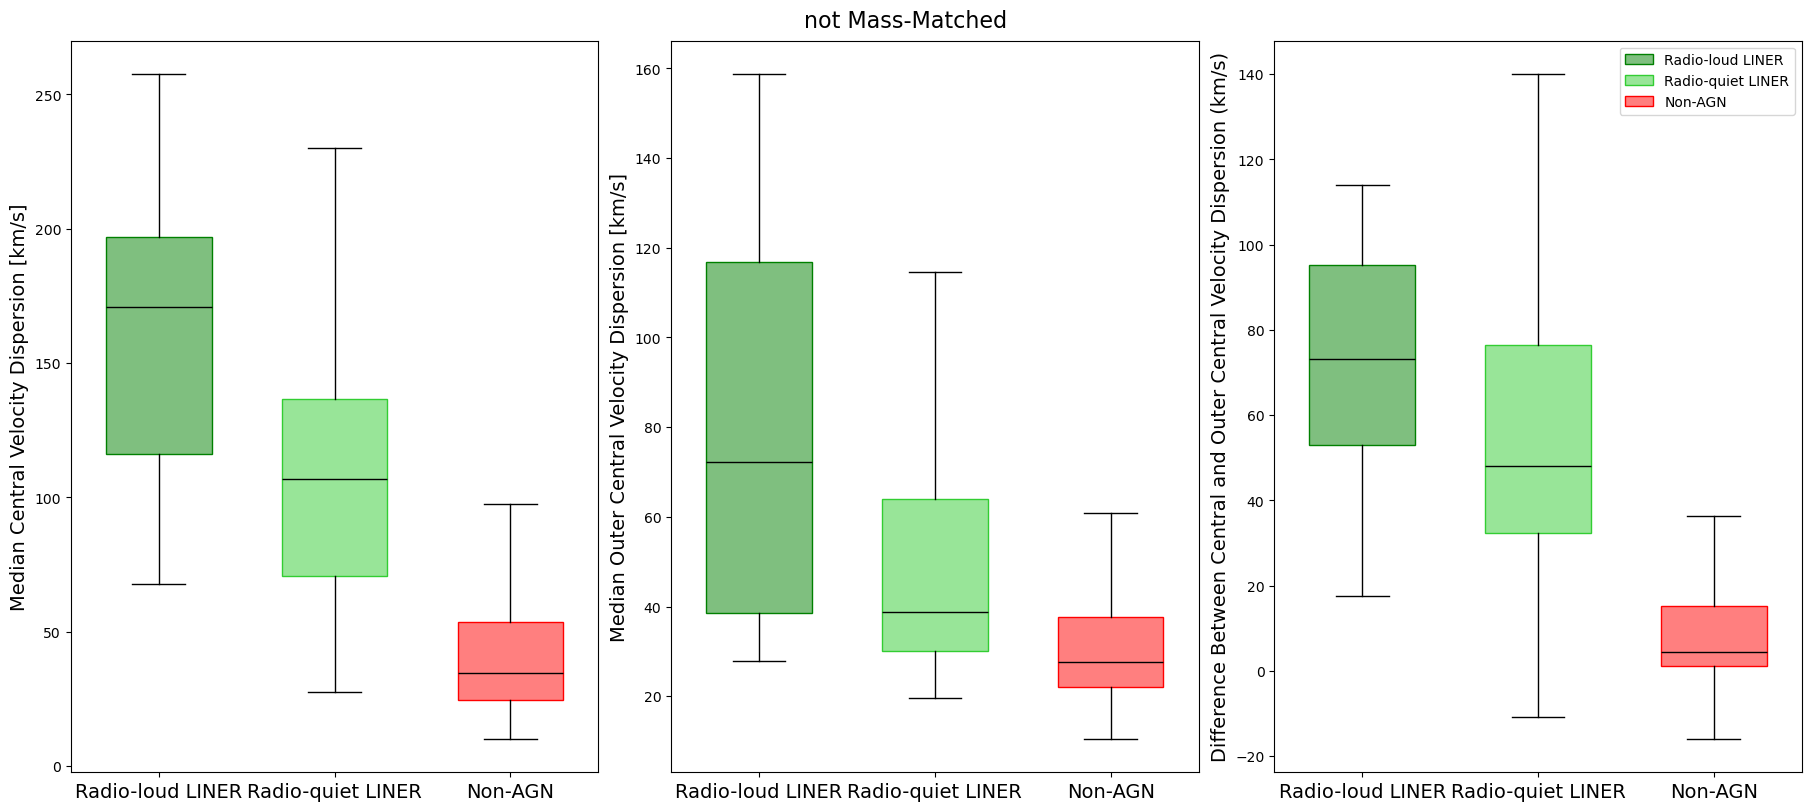

In [6]:
valid_radio_loud_LINER_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 1)
valid_radio_quiet_LINER_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 0)
valid_nonAGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [ -1, 0, 1, 2])

valid_radio_loud_LINER_CATIDs = valid_Summary_table_hdu['CATID'][valid_radio_loud_LINER_mask]
valid_radio_quiet_LINER_CATIDs = valid_Summary_table_hdu['CATID'][valid_radio_quiet_LINER_mask]
valid_nonAGN_CATIDs = valid_Summary_table_hdu['CATID'][valid_nonAGN_mask]


gassig_statistics = ('5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP')
ylabels = ('Median Central Velocity Dispersion [km/s]', 'Median Outer Central Velocity Dispersion [km/s]')
LINER_colour = 'green'
nonLINER_colour = 'limegreen'
nonAGN_colour = 'red'
showfliers = False

reduced_gassig_statistics_table = gassig_statistics_table.copy()
reduced_gassig_statistics_table.keep_columns(['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'])
temporary_radio_loud_LINER_table = join(Table({'CATID': valid_radio_loud_LINER_CATIDs}), reduced_gassig_statistics_table, keys='CATID', join_type='left')
temporary_radio_loud_LINER_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['radio_loud_LINER_5SPAXEL_MEDIAN_VEL_DISP', 'radio_loud_LINER_OUTSIDE_5SPAXEL_VEL_DISP'])
temporary_radio_quiet_LINER_table = join(Table({'CATID': valid_radio_quiet_LINER_CATIDs}), reduced_gassig_statistics_table, keys='CATID', join_type='left')
temporary_radio_quiet_LINER_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['radio_quiet_LINER_5SPAXEL_MEDIAN_VEL_DISP', 'radio_quiet_LINER_OUTSIDE_5SPAXEL_VEL_DISP'])
temporary_nonAGN_table = join(Table({'CATID': valid_nonAGN_CATIDs}), reduced_gassig_statistics_table, keys='CATID', join_type='left')
temporary_nonAGN_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], ['nonAGN_5SPAXEL_MEDIAN_VEL_DISP', 'nonAGN_OUTSIDE_5SPAXEL_VEL_DISP'])

full_temporary_matched_table = astropy.table.vstack([temporary_radio_loud_LINER_table, temporary_radio_quiet_LINER_table, temporary_nonAGN_table], join_type='outer')

fig, axs = plt.subplots(1,3, figsize=(18, 8), constrained_layout=True)
fig.suptitle('not Mass-Matched', fontsize=16)

for i, gassig_statistic in enumerate(gassig_statistics):
    temporary_matched_table = full_temporary_matched_table
    ax = axs[i]
    ax.boxplot(temporary_matched_table[f'radio_loud_LINER_{gassig_statistic}'][~np.isnan(temporary_matched_table[f'radio_loud_LINER_{gassig_statistic}'])], 
               positions=[1], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(LINER_colour, 0.5), color=LINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
    ax.boxplot(temporary_matched_table[f'radio_quiet_LINER_{gassig_statistic}'][~np.isnan(temporary_matched_table[f'radio_quiet_LINER_{gassig_statistic}'])], 
               positions=[2], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonLINER_colour, 0.5), color=nonLINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
    ax.boxplot(temporary_matched_table[f'nonAGN_{gassig_statistic}'][~np.isnan(temporary_matched_table[f'nonAGN_{gassig_statistic}'])], 
               positions=[3], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonAGN_colour, 0.5), color=nonAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Radio-loud LINER', 'Radio-quiet LINER', 'Non-AGN'], fontsize=14)
    ax.set_ylabel(ylabels[i], fontsize=14)

# plot difference between central and Outer central dispersion boxplot
ax =axs[2]
radio_loud_LINER_disp_diff = full_temporary_matched_table['radio_loud_LINER_5SPAXEL_MEDIAN_VEL_DISP'] - full_temporary_matched_table['radio_loud_LINER_OUTSIDE_5SPAXEL_VEL_DISP']
radio_quiet_LINER_disp_diff = full_temporary_matched_table['radio_quiet_LINER_5SPAXEL_MEDIAN_VEL_DISP'] - full_temporary_matched_table['radio_quiet_LINER_OUTSIDE_5SPAXEL_VEL_DISP']
nonAGN_disp_diff = full_temporary_matched_table['nonAGN_5SPAXEL_MEDIAN_VEL_DISP'] - full_temporary_matched_table['nonAGN_OUTSIDE_5SPAXEL_VEL_DISP']
ax.boxplot(radio_loud_LINER_disp_diff[~np.isnan(radio_loud_LINER_disp_diff)], positions=[1], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(LINER_colour, 0.5), color=LINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.boxplot(radio_quiet_LINER_disp_diff[~np.isnan(radio_quiet_LINER_disp_diff)], positions=[2], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonLINER_colour, 0.5), color=nonLINER_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.boxplot(nonAGN_disp_diff[~np.isnan(nonAGN_disp_diff)], positions=[3], widths=0.6, patch_artist=True, boxprops
                =dict(facecolor=mcolors.to_rgba(nonAGN_colour, 0.5), color=nonAGN_colour), medianprops=dict(color='black'), showfliers=showfliers)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Radio-loud LINER', 'Radio-quiet LINER', 'Non-AGN'], fontsize=14)
ax.set_ylabel('Difference Between Central and Outer Central Velocity Dispersion (km/s)', fontsize=14)
ax.legend(['Radio-loud LINER', 'Radio-quiet LINER', 'Non-AGN'])
plt.show()




# Violin Plots and ks statistics

In [ ]:
def bootstrap_median_ci(x, n_boot=1000, ci=68):
    boots = np.median(np.random.choice(x, (n_boot, len(x))), axis=1)
    med = np.median(x)
    err = np.percentile(boots, [50 - ci/2, 50 + ci/2])
    return med, med - err[0], err[1] - med   # median, lower_err, upper_err

## Radio-loud and -quiet and non-AGN

['radio_loud_AGN_CATID', 'radio_quiet_AGN_CATID', 'min_diff_1', 'nonAGN_CATID', 'min_diff_2', 'radio_loud_AGN_5SPAXEL_MEDIAN_VEL_DISP', 'radio_loud_AGN_OUTSIDE_5SPAXEL_VEL_DISP', 'radio_quiet_AGN_5SPAXEL_MEDIAN_VEL_DISP', 'radio_quiet_AGN_OUTSIDE_5SPAXEL_VEL_DISP', 'nonAGN_5SPAXEL_MEDIAN_VEL_DISP', 'nonAGN_OUTSIDE_5SPAXEL_VEL_DISP']
Radio-loud AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 144.5523910522461, -14.032615661621094, +10.413566589355469
Radio-quiet AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 113.68123245239258, -4.644111633300781, +3.090839385986328
Non-AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 89.93312072753906, -12.985893249511719, +5.366386413574219
Radio-loud AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 66.07212829589844, -6.339305877685547, +6.2220001220703125
Radio-quiet AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 40.99929618835449, -4.999914169311523, +12.300745010375977
Non-AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 47.470964431762695, -1.6245574951171875, +4.681364059448242


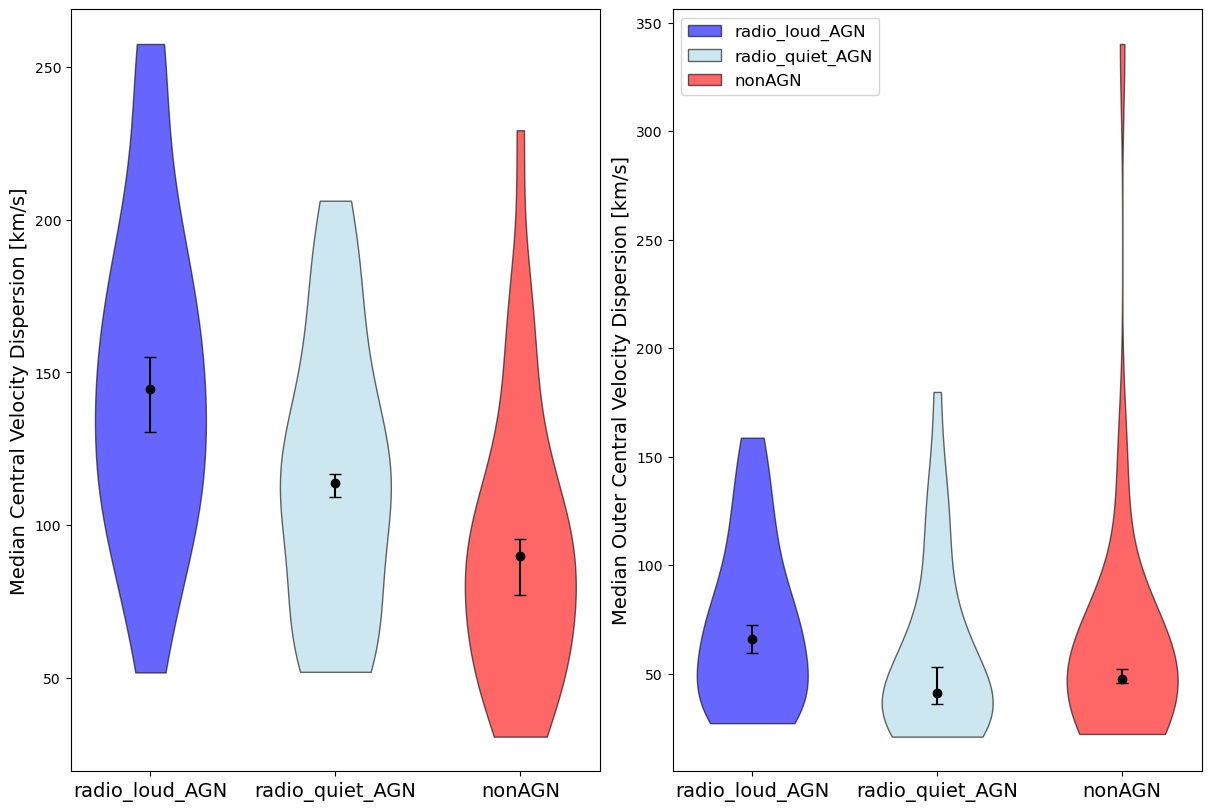


 5SPAXEL_MEDIAN_VEL_DISP KS Test Results:
Radio-loud AGN and Radio-quiet AGN      : KS statistic = 0.2812 , p-value = 0.1601                               
Radio-loud AGN and Non-AGN              : KS statistic = 0.5312 , p-value = 0.0002    (strong evidence to reject)
Radio-quiet AGN and Non-AGN             : KS statistic = 0.3750 , p-value = 0.0214    (strong evidence to reject)

 5SPAXEL_MEDIAN_VEL_DISP Anderson-Darling Test Results:
Radio-loud AGN and Radio-quiet AGN      : AD statistic = 2.9088 , significance level = 0.0211    (strong evidence to reject)
Radio-loud AGN and Non-AGN              : AD statistic = 10.5807, significance level = 0.0010    (strong evidence to reject)
Radio-quiet AGN and Non-AGN             : AD statistic = 2.4681 , significance level = 0.0316    (strong evidence to reject)

 OUTSIDE_5SPAXEL_VEL_DISP KS Test Results:
Radio-loud AGN and Radio-quiet AGN      : KS statistic = 0.2812 , p-value = 0.1601                               
Radio-loud AGN and Non-AG

C:\Users\mspan\AppData\Local\Temp\ipykernel_35952\2878170572.py:129: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  result = anderson_ksamp([data1, data2])
C:\Users\mspan\AppData\Local\Temp\ipykernel_35952\2878170572.py:129: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  result = anderson_ksamp([data1, data2])


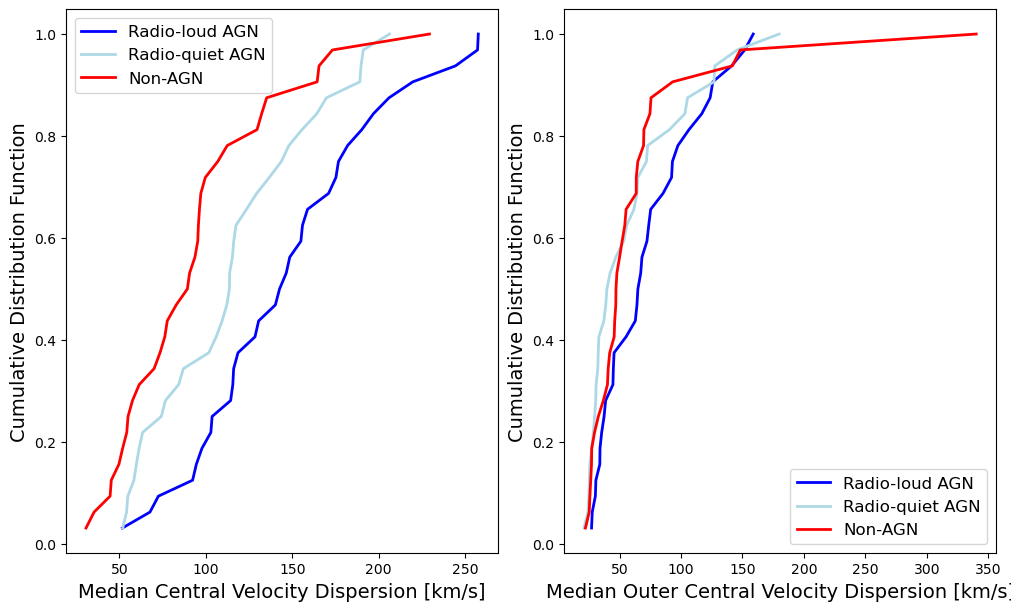

In [111]:
valid_radio_loud_AGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 1)
valid_radio_quiet_AGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 0)
valid_nonAGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [ -1, 0, 1, 2])

radioAGN_samples_dict = {'radio_loud_AGN' : ('Radio-loud AGN', radioAGN_colour,  0, valid_radio_loud_AGN_mask),
                         'radio_quiet_AGN' : ('Radio-quiet AGN', nonradioAGN_colour, 1, valid_radio_quiet_AGN_mask),
                            'nonAGN' : ('Non-AGN', nonradioNonAGN_colour, 2, valid_nonAGN_mask)}
                        

gassig_statistics = ('5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP')
ylabels = ('Median Central Velocity Dispersion [km/s]', 'Median Outer Central Velocity Dispersion [km/s]')
AGN_colour = 'blue'
nonAGN_colour = 'red'


def get_full_mached_table(gassig_statistics_table, valid_Summary_table_hdu, gassig_statistics, samples_dict):
    valid_1_CATIDs = valid_Summary_table_hdu['CATID'][samples_dict[list(samples_dict.keys())[0]][3]]
    valid_2_CATIDs = valid_Summary_table_hdu['CATID'][samples_dict[list(samples_dict.keys())[1]][3]]
    valid_3_CATIDs = valid_Summary_table_hdu['CATID'][samples_dict[list(samples_dict.keys())[2]][3]]

    matched_1_2_table = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_1_CATIDs, valid_2_CATIDs,  distribution_plots=False, scatter_plot=False)
    matched_1_2_table.rename_column('Input_CATID', f'{list(samples_dict.keys())[0]}_CATID')
    matched_1_2_table.rename_column('Matched_CATID', f'{list(samples_dict.keys())[1]}_CATID')

    matched_1_3_table = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, valid_1_CATIDs, valid_3_CATIDs,  distribution_plots=False, scatter_plot=False)
    matched_1_3_table.rename_column('Input_CATID', f'{list(samples_dict.keys())[0]}_CATID')
    matched_1_3_table.rename_column('Matched_CATID', f'{list(samples_dict.keys())[2]}_CATID')

    full_matched_table = join(matched_1_2_table, matched_1_3_table, keys=f'{list(samples_dict.keys())[0]}_CATID', join_type='outer')
    for sample_name in samples_dict.keys():
        full_matched_table = join(full_matched_table, gassig_statistics_table[['CATID', '5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP']], keys_left=f'{sample_name}_CATID', keys_right='CATID', join_type='left')
        full_matched_table.rename_columns(['5SPAXEL_MEDIAN_VEL_DISP', 'OUTSIDE_5SPAXEL_VEL_DISP'], [f'{sample_name}_5SPAXEL_MEDIAN_VEL_DISP', f'{sample_name}_OUTSIDE_5SPAXEL_VEL_DISP'])
        full_matched_table.remove_column('CATID')

    return full_matched_table

def get_violin_dispersion_plots(axs, full_matched_table, gassig_statistics, ylabels, samples_dict):

    for i, gassig_statistic in enumerate(gassig_statistics):
        # get the mask of all valid gassig_statistic values
        gassig_statistic_mask = np.zeros_like(full_matched_table[list(samples_dict.keys())[0] + '_CATID'], dtype=bool)
        for sample_prefix, (sample_name, _, _, _) in samples_dict.items():
            gassig_statistic_mask = gassig_statistic_mask | np.isnan(full_matched_table[f'{sample_prefix}_{gassig_statistic}'])

        temporary_matched_table = full_matched_table[~gassig_statistic_mask]
        ax = axs[i]


        # plot the means and confidence intervals using bootstrapping
        for sample_prefix, (sample_name, sample_colour, j, _) in samples_dict.items():
            data = temporary_matched_table[f'{sample_prefix}_{gassig_statistic}']
            med, lower_err, upper_err = bootstrap_median_ci(data)
            print(f"{sample_name} - {gassig_statistic}: Median = {med}, -{lower_err}, +{upper_err}")


            # big-endian data need to convert to little-endian
            data = data.astype(data.dtype.newbyteorder('='))

            # violin plot
            parts = ax.violinplot(data, positions=[j+1], widths=0.6, showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor(mcolors.to_rgba(sample_colour, 0.5))
                pc.set_edgecolor('black')
                pc.set_alpha(0.6)

            # plot median and error bars
            ax.errorbar(j+1, med, yerr=[[lower_err], [upper_err]], fmt='o', color='black', capsize=4, lw=1.5, label='Median with 68% CI' if j==0 else "")

        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels([keys for keys in samples_dict.keys()], fontsize=14)
        # ax.set_xticklabels(['Radio-loud AGN', 'Radio-quiet AGN', 'Non-AGN'], fontsize=14)
        ax.set_ylabel(ylabels[i], fontsize=14)

        if i==1:
            ax.legend([keys for keys in samples_dict.keys()], fontsize=12)

    for ax in axs:
        ax.yaxis.set_tick_params(labelleft=True)
        ax.yaxis.offsetText.set_visible(True)  # show scientific notation if used

    return None


def get_dispersion_ks_statistics(axs, full_matched_table, samples_dict, gassig_statistics):
    for i, gassig_statistic in enumerate(gassig_statistics):
        gassig_statistic_mask = np.zeros_like(full_matched_table[list(samples_dict.keys())[0] + '_CATID'], dtype=bool)
        for sample_prefix, (sample_name, _, _, _) in samples_dict.items():
            gassig_statistic_mask = gassig_statistic_mask | np.isnan(full_matched_table[f'{sample_prefix}_{gassig_statistic}'])
            pass

        temporary_matched_table = full_matched_table[~gassig_statistic_mask]    
        
        ax = axs[i]
        

        for sample_prefix, (sample_name, sample_colour, j, _) in samples_dict.items():
            data = temporary_matched_table[f'{sample_prefix}_{gassig_statistic}']
            data = data[~np.isnan(data)]
            # sort the data
            data = np.sort(data)
            # get the CDF values
            cdf = np.arange(1, len(data)+1) / len(data)
            ax.plot(data, cdf, color=sample_colour, lw=2, label=sample_name)

        ax.set_xlabel(ylabels[i], fontsize=14)
        ax.set_ylabel('Cumulative Distribution Function', fontsize=14)
        ax.legend(fontsize=12)

    # now fit the ks statistics
        print(f"\n {gassig_statistic} KS Test Results:")
        for (sample_prefix1, (sample_name1, _, _, _)), (sample_prefix2, (sample_name2, _, _, _)) in combinations(samples_dict.items(), 2):
            data1 = temporary_matched_table[f'{sample_prefix1}_{gassig_statistic}']
            data1 = data1[~np.isnan(data1)]
            data2 = temporary_matched_table[f'{sample_prefix2}_{gassig_statistic}']
            data2 = data2[~np.isnan(data2)]
            ks_stat, p_value = ks_2samp(data1, data2)
            result_str = ""
            if p_value < 0.05:
                result_str = "(strong evidence to reject)"
            print(f"{f'{sample_name1} and {sample_name2}':<40}: KS statistic = {ks_stat:<7.4f}, p-value = {p_value:.4f} {result_str:>30}")

        # also fo Adderson-Darling test
        print(f"\n {gassig_statistic} Anderson-Darling Test Results:")
        for (sample_prefix1, (sample_name1, _, _, _)), (sample_prefix2, (sample_name2, _, _, _)) in combinations(samples_dict.items(), 2):  
            data1 = temporary_matched_table[f'{sample_prefix1}_{gassig_statistic}']
            data1 = data1[~np.isnan(data1)]
            data2 = temporary_matched_table[f'{sample_prefix2}_{gassig_statistic}']
            data2 = data2[~np.isnan(data2)]
            result = anderson_ksamp([data1, data2])

            result_str = ""
            if result.significance_level < 0.05:
                result_str = "(strong evidence to reject)"
            print(f"{f'{sample_name1} and {sample_name2}':<40}: AD statistic = {result.statistic:<7.4f}, significance level = {result.significance_level:.4f} {result_str:>30}")

    return None

full_radioAGN_matched_table = get_full_mached_table(gassig_statistics_table, valid_Summary_table_hdu, gassig_statistics, radioAGN_samples_dict)
print(full_radioAGN_matched_table.colnames)
fig, axs = plt.subplots(1,2, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()
get_violin_dispersion_plots(axs, full_radioAGN_matched_table, gassig_statistics, ylabels, radioAGN_samples_dict)
plt.show()

fig, axs = plt.subplots(1,2, figsize=(10, 6), constrained_layout=True)
axs = axs.flatten()
get_dispersion_ks_statistics(axs, full_radioAGN_matched_table, radioAGN_samples_dict, gassig_statistics)


## HERG v LERG v nonAGN

['HERG_CATID', 'LERG_CATID', 'min_diff_1', 'nonAGN_CATID', 'min_diff_2', 'HERG_5SPAXEL_MEDIAN_VEL_DISP', 'HERG_OUTSIDE_5SPAXEL_VEL_DISP', 'LERG_5SPAXEL_MEDIAN_VEL_DISP', 'LERG_OUTSIDE_5SPAXEL_VEL_DISP', 'nonAGN_5SPAXEL_MEDIAN_VEL_DISP', 'nonAGN_OUTSIDE_5SPAXEL_VEL_DISP']
HERG - 5SPAXEL_MEDIAN_VEL_DISP: Median = 87.29752731323242, -10.887828826904297, +5.025066375732422
LERG - 5SPAXEL_MEDIAN_VEL_DISP: Median = 71.27446365356445, -5.9553985595703125, +7.052684783935547
Non-AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 47.88090515136719, -2.1219482421875, +2.264598846435547
HERG - OUTSIDE_5SPAXEL_VEL_DISP: Median = 55.394744873046875, -4.299530029296875, +8.776092529296875
LERG - OUTSIDE_5SPAXEL_VEL_DISP: Median = 50.127973556518555, -3.028169631958008, +2.5949344635009766
Non-AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 31.795202255249023, -1.3630790710449219, +0.9433002471923828


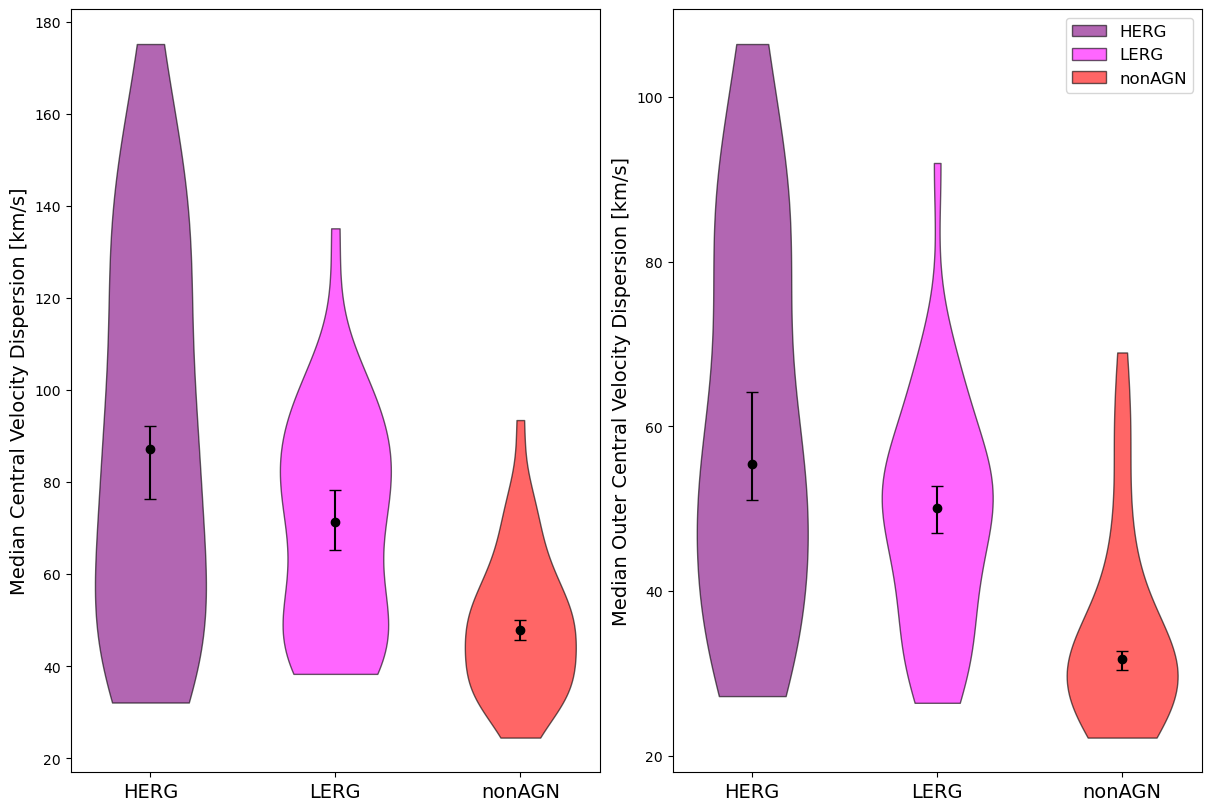


 5SPAXEL_MEDIAN_VEL_DISP KS Test Results:
HERG and LERG                           : KS statistic = 0.3333 , p-value = 0.0359    (strong evidence to reject)
HERG and Non-AGN                        : KS statistic = 0.5833 , p-value = 0.0000    (strong evidence to reject)
LERG and Non-AGN                        : KS statistic = 0.4444 , p-value = 0.0014    (strong evidence to reject)

 5SPAXEL_MEDIAN_VEL_DISP Anderson-Darling Test Results:
HERG and LERG                           : AD statistic = 2.4930 , significance level = 0.0309    (strong evidence to reject)
HERG and Non-AGN                        : AD statistic = 12.8955, significance level = 0.0010    (strong evidence to reject)
LERG and Non-AGN                        : AD statistic = 10.1935, significance level = 0.0010    (strong evidence to reject)

 OUTSIDE_5SPAXEL_VEL_DISP KS Test Results:
HERG and LERG                           : KS statistic = 0.3333 , p-value = 0.0359    (strong evidence to reject)
HERG and Non-AGN         

C:\Users\mspan\AppData\Local\Temp\ipykernel_35952\2878170572.py:129: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  result = anderson_ksamp([data1, data2])


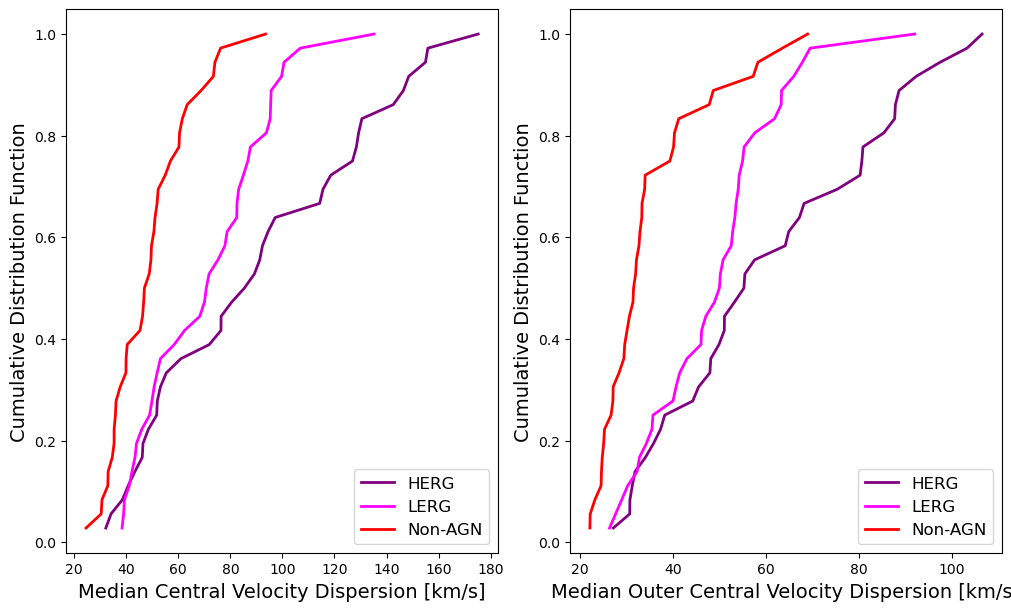

In [112]:
valid_HERG_mask = (valid_Summary_table_hdu['IS_HERG'] == 1)
valid_LERG_mask = (valid_Summary_table_hdu['IS_HERG'] == 0)
valid_nonAGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [ -1, 0, 1, 2]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 0)

HERG_samples_dict = {'HERG' : ('HERG', HERG_colour,  0, valid_HERG_mask),
                         'LERG' : ('LERG', LERG_colour, 1, valid_LERG_mask),
                            'nonAGN' : ('Non-AGN', nonAGN_colour, 2, valid_nonAGN_mask)}

full_HERG_matched_table = get_full_mached_table(gassig_statistics_table, valid_Summary_table_hdu, gassig_statistics, HERG_samples_dict)
print(full_HERG_matched_table.colnames)
fig, axs = plt.subplots(1,2, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()
get_violin_dispersion_plots(axs, full_HERG_matched_table, gassig_statistics, ylabels, HERG_samples_dict)
plt.show()

fig, axs = plt.subplots(1,2, figsize=(10, 6), constrained_layout=True)
axs = axs.flatten()
get_dispersion_ks_statistics(axs, full_HERG_matched_table, HERG_samples_dict, gassig_statistics)
plt.show()

## Radio loud LINER and Radio quiet LINER and nonAGN

['radio_loud_LINER_CATID', 'radio_quiet_LINER_CATID', 'min_diff_1', 'nonAGN_CATID', 'min_diff_2', 'radio_loud_LINER_5SPAXEL_MEDIAN_VEL_DISP', 'radio_loud_LINER_OUTSIDE_5SPAXEL_VEL_DISP', 'radio_quiet_LINER_5SPAXEL_MEDIAN_VEL_DISP', 'radio_quiet_LINER_OUTSIDE_5SPAXEL_VEL_DISP', 'nonAGN_5SPAXEL_MEDIAN_VEL_DISP', 'nonAGN_OUTSIDE_5SPAXEL_VEL_DISP']
Radio-loud LINER - 5SPAXEL_MEDIAN_VEL_DISP: Median = 170.99307250976562, -24.499435424804688, +10.97509765625
Radio-quiet LINER - 5SPAXEL_MEDIAN_VEL_DISP: Median = 136.6751708984375, -19.23846435546875, +11.313796997070312
Non-AGN - 5SPAXEL_MEDIAN_VEL_DISP: Median = 96.27808380126953, -5.6994781494140625, +16.05895233154297
Radio-loud LINER - OUTSIDE_5SPAXEL_VEL_DISP: Median = 72.29412841796875, -27.333740234375, +3.0527114868164062
Radio-quiet LINER - OUTSIDE_5SPAXEL_VEL_DISP: Median = 55.78938674926758, -8.811283111572266, +16.079792022705078
Non-AGN - OUTSIDE_5SPAXEL_VEL_DISP: Median = 63.59486389160156, -16.649017333984375, +6.20687866210937

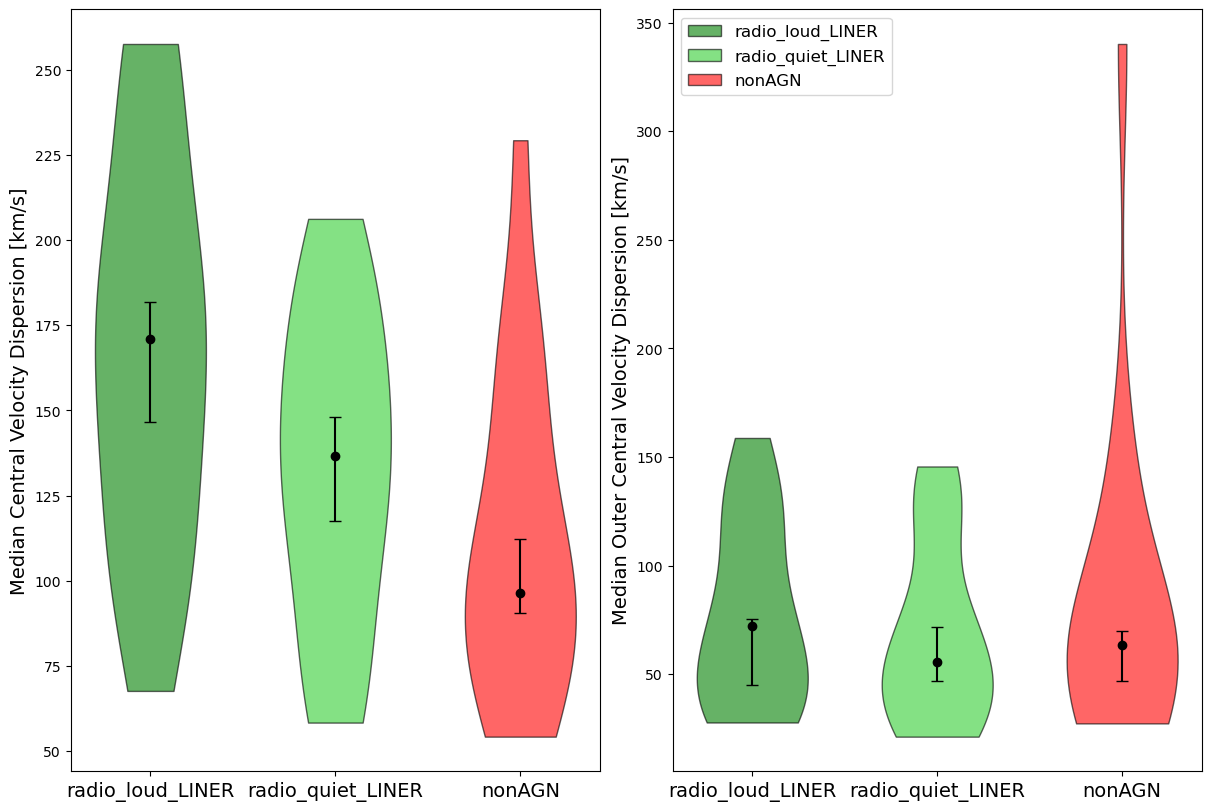


 5SPAXEL_MEDIAN_VEL_DISP KS Test Results:
Radio-loud LINER and Radio-quiet LINER  : KS statistic = 0.2941 , p-value = 0.4654                               
Radio-loud LINER and Non-AGN            : KS statistic = 0.5294 , p-value = 0.0156    (strong evidence to reject)
Radio-quiet LINER and Non-AGN           : KS statistic = 0.3529 , p-value = 0.2450                               

 5SPAXEL_MEDIAN_VEL_DISP Anderson-Darling Test Results:
Radio-loud LINER and Radio-quiet LINER  : AD statistic = 0.9279 , significance level = 0.1357                               
Radio-loud LINER and Non-AGN            : AD statistic = 4.9333 , significance level = 0.0037    (strong evidence to reject)
Radio-quiet LINER and Non-AGN           : AD statistic = 0.5282 , significance level = 0.2008                               

 OUTSIDE_5SPAXEL_VEL_DISP KS Test Results:
Radio-loud LINER and Radio-quiet LINER  : KS statistic = 0.1765 , p-value = 0.9631                               
Radio-loud LINER and Non-

C:\Users\mspan\AppData\Local\Temp\ipykernel_35952\2878170572.py:129: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  result = anderson_ksamp([data1, data2])


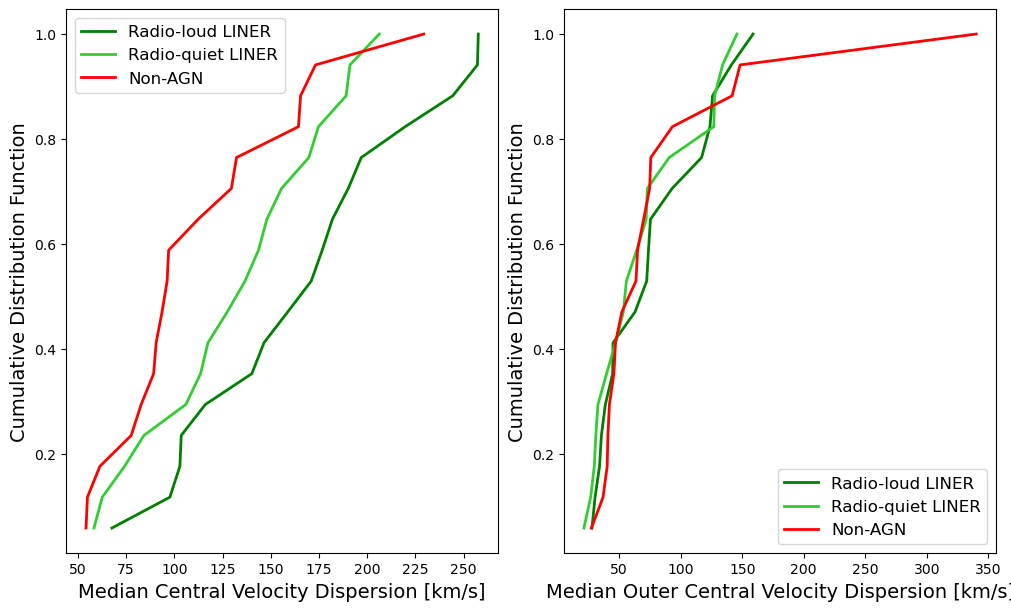

In [113]:
valid_radio_loud_LINER_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 1)
valid_radio_quiet_LINER_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 10]) & (valid_Summary_table_hdu['IS_RADIOSOURCE'] == 0)
valid_nonAGN_mask = np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], [ -1, 0, 1, 2])

LINER_samples_dict = {'radio_loud_LINER' : ('Radio-loud LINER', radioLINER_colour ,  0, valid_radio_loud_LINER_mask),
                         'radio_quiet_LINER' : ('Radio-quiet LINER', nonradioLINER_colour, 1, valid_radio_quiet_LINER_mask),
                            'nonAGN' : ('Non-AGN', nonAGN_colour, 2, valid_nonAGN_mask)}

full_LINER_matched_table = get_full_mached_table(gassig_statistics_table, valid_Summary_table_hdu, gassig_statistics, LINER_samples_dict)
print(full_LINER_matched_table.colnames)

fig, axs = plt.subplots(1,2, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()
get_violin_dispersion_plots(axs, full_LINER_matched_table, gassig_statistics, ylabels, LINER_samples_dict)
plt.show()

fig, axs = plt.subplots(1,2, figsize=(10, 6), constrained_layout=True)
axs = axs.flatten()
get_dispersion_ks_statistics(axs, full_LINER_matched_table, LINER_samples_dict, gassig_statistics)
plt.show()